In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/new-york-city-taxi-fare-prediction/train.csv


# EDA

## Data information

In [2]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

In [3]:
data=pd.read_csv(r'/kaggle/input/new-york-city-taxi-fare-prediction/train.csv')

In [4]:
data.head(5)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [5]:

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                50000 non-null  object 
 1   fare_amount        50000 non-null  float64
 2   pickup_datetime    50000 non-null  object 
 3   pickup_longitude   50000 non-null  float64
 4   pickup_latitude    50000 non-null  float64
 5   dropoff_longitude  50000 non-null  float64
 6   dropoff_latitude   50000 non-null  float64
 7   passenger_count    50000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 3.1+ MB


In [6]:
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,11.364171,-72.509756,39.933759,-72.504616,39.926251,1.667840
std,9.685557,10.393860,6.224857,10.407570,6.014737,1.289195
min,-5.000000,-75.423848,-74.006893,-84.654241,-74.006377,0.000000
25%,6.000000,-73.992062,40.734880,-73.991152,40.734372,1.000000
50%,8.500000,-73.981840,40.752678,-73.980082,40.753372,1.000000
75%,12.500000,-73.967148,40.767360,-73.963584,40.768167,2.000000
max,200.000000,40.783472,401.083332,40.851027,43.415190,6.000000


In [7]:
count_duplicated = data.duplicated().sum()
print(f'Dataset having {count_duplicated} duplicated values')

Dataset having 0 duplicated values


In [8]:
# Counting Null Values
count_null_df=pd.DataFrame({'columns':data.columns,'number_of_nulls_values':data.isna().sum()})
count_null_df.set_index('columns').sort_values(by='number_of_nulls_values', ascending = False)

,number_of_nulls_values
columns,
key,0
fare_amount,0
pickup_datetime,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,0
dropoff_latitude,0
passenger_count,0


In [9]:
len(data)

50000

## Data Preprocessing

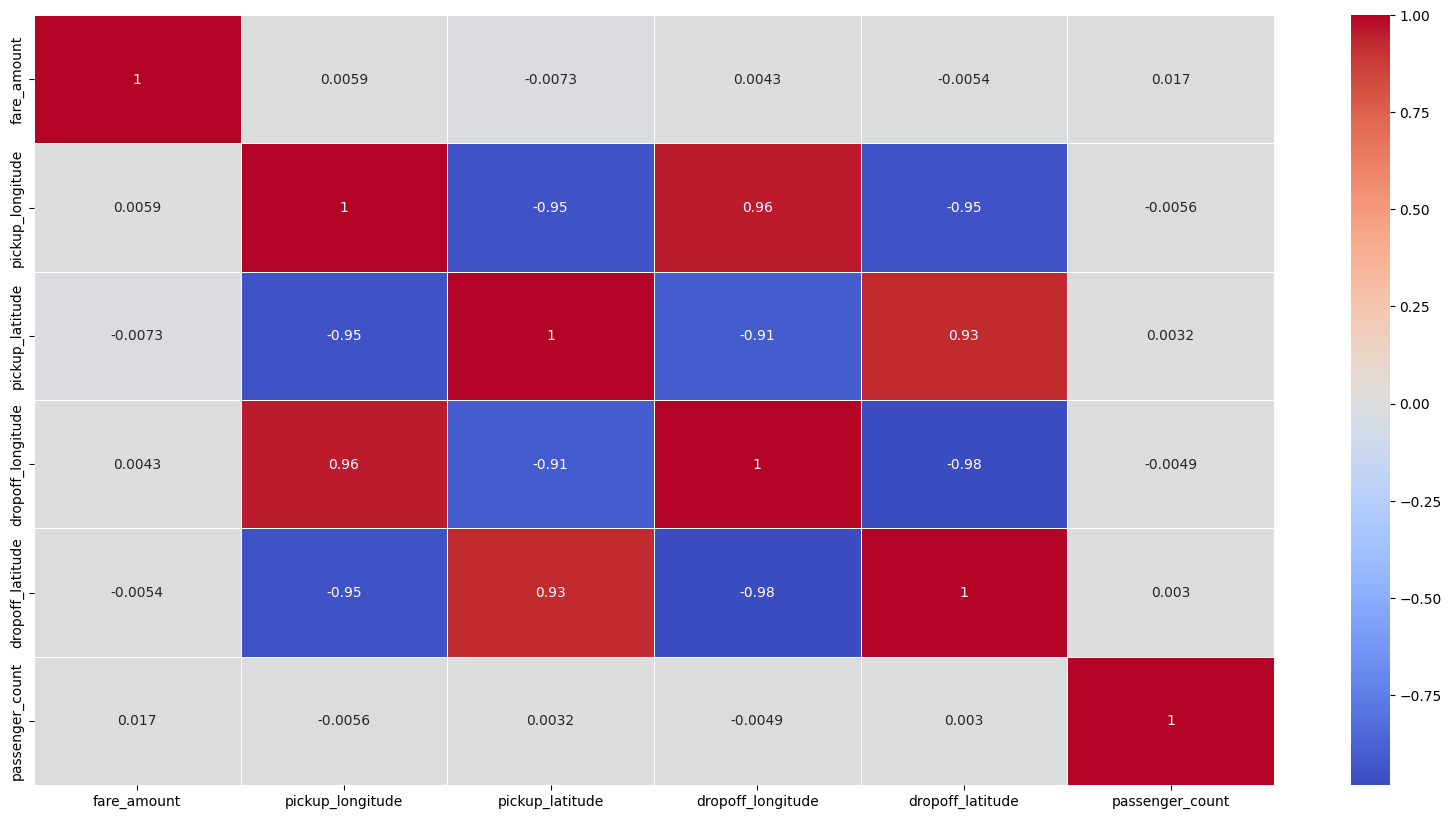

In [10]:
# check for multi-colinearity
f, ax = plt.subplots(figsize = (20, 10))
data2=data.drop(['pickup_datetime','key'],axis=1)
sns.heatmap(data2.corr(),ax = ax, annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()

# Feature Extraction

In [11]:
def haversine(lon1, lat1, lon2, lat2):
    # Convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # Haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371 * c
    return km

In [12]:
data["distance"] = data.apply(lambda row: haversine(row['pickup_longitude'], row['pickup_latitude'], row['dropoff_longitude'], row['dropoff_latitude']), axis=1)

In [13]:
data.head(5)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,1.030764
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,8.450134
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,1.389525
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,2.799270
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,1.999157


In [14]:
data['fare_per_distance'] = data['fare_amount'] / data['distance']

In [15]:
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['pickup_dayofweek'] = data['pickup_datetime'].dt.dayofweek
data['pickup_month'] = data['pickup_datetime'].dt.month
data['pickup_hour'] = data['pickup_datetime'].dt.hour
data['pickup_minute'] = data['pickup_datetime'].dt.minute
data['passenger_count_bin'] = pd.cut(data['passenger_count'], bins=[0, 2, 4, 6], labels=['small', 'medium', 'large'])

In [16]:
one_hot = pd.get_dummies(data['passenger_count_bin'], prefix='passenger_count_bin')

# Concatenate the one-hot encoded columns with the original DataFrame
data = pd.concat([data, one_hot], axis=1)

# Drop the original 'labels' column if needed
data.drop(['passenger_count_bin','pickup_datetime'], axis=1, inplace=True)
data.drop(['key'], axis=1, inplace=True)


In [17]:
data.head(5)

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,fare_per_distance,pickup_dayofweek,pickup_month,pickup_hour,pickup_minute,passenger_count_bin_small,passenger_count_bin_medium,passenger_count_bin_large
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,1.030764,4.365694,0,6,17,26,True,False,False
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,8.450134,1.999968,1,1,16,52,True,False,False
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,1.389525,4.102121,3,8,0,35,True,False,False
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2.799270,2.750717,5,4,4,30,True,False,False
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,1.999157,2.651118,1,3,7,51,True,False,False


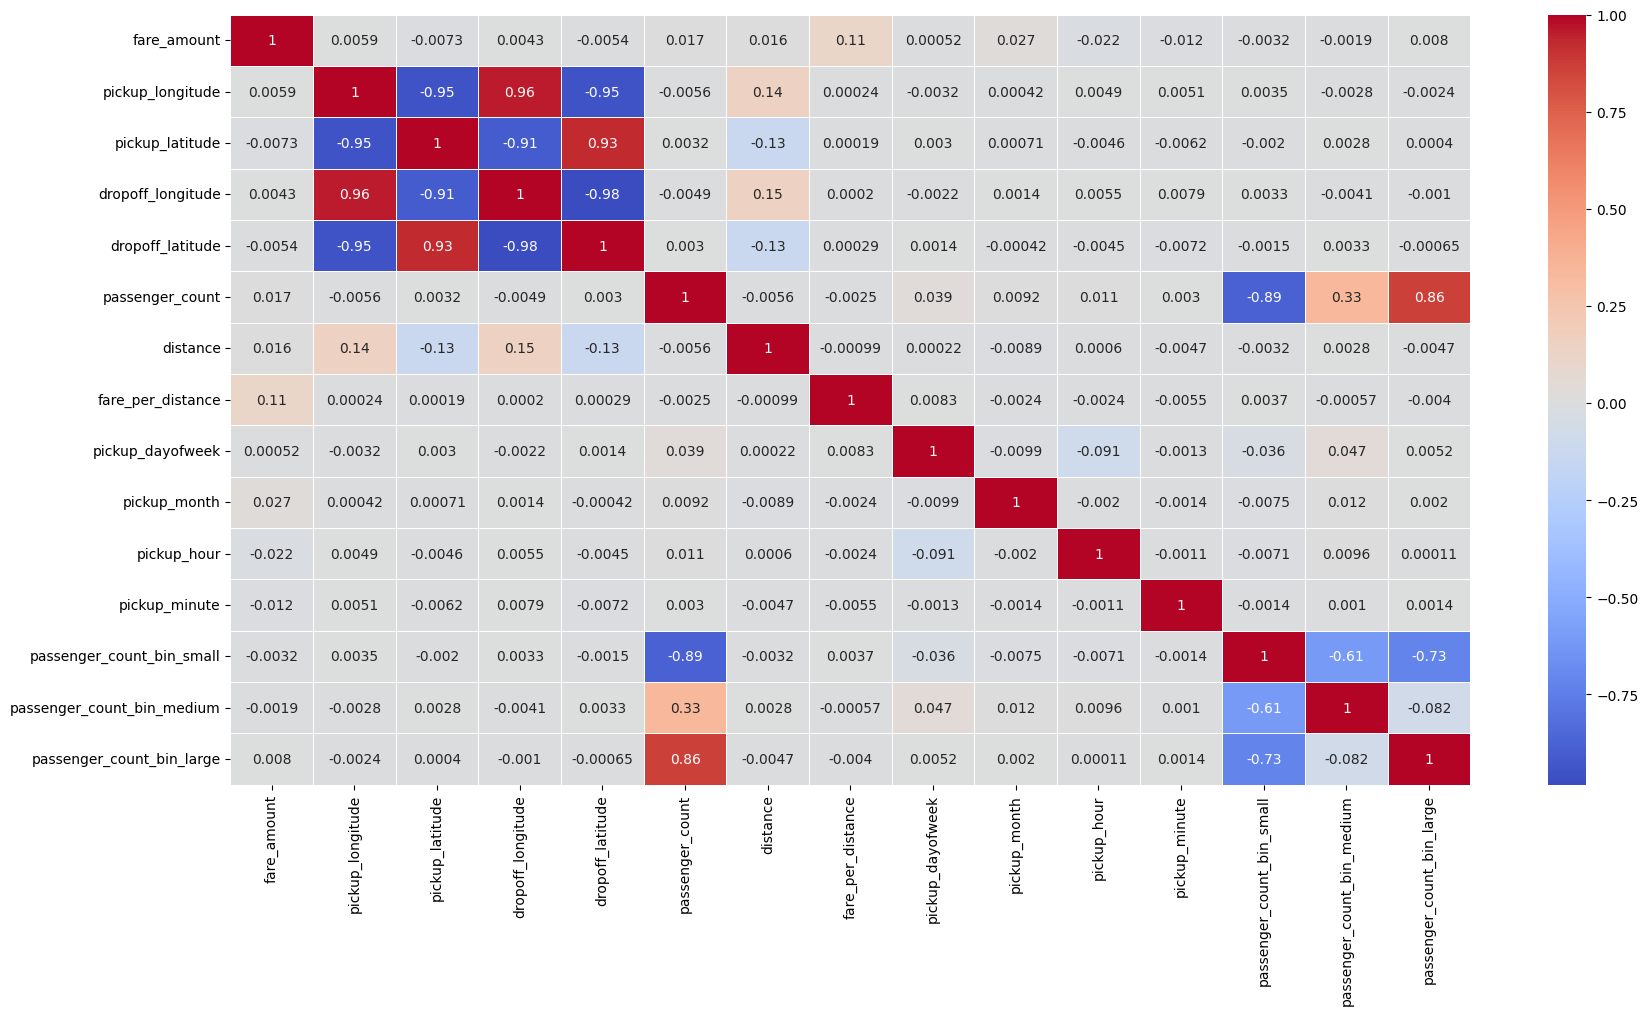

In [18]:
f, ax = plt.subplots(figsize = (20, 10))
sns.heatmap(data.corr(),ax = ax, annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()

In [27]:
count_null_df=pd.DataFrame({'columns':data.columns,'number_of_nulls_values':data.isna().sum()})
count_null_df.set_index('columns').sort_values(by='number_of_nulls_values', ascending = False)

,number_of_nulls_values
columns,
fare_amount,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,0
dropoff_latitude,0
passenger_count,0
distance,0
fare_per_distance,0
pickup_dayofweek,0


## Feature Selection

<Axes: >

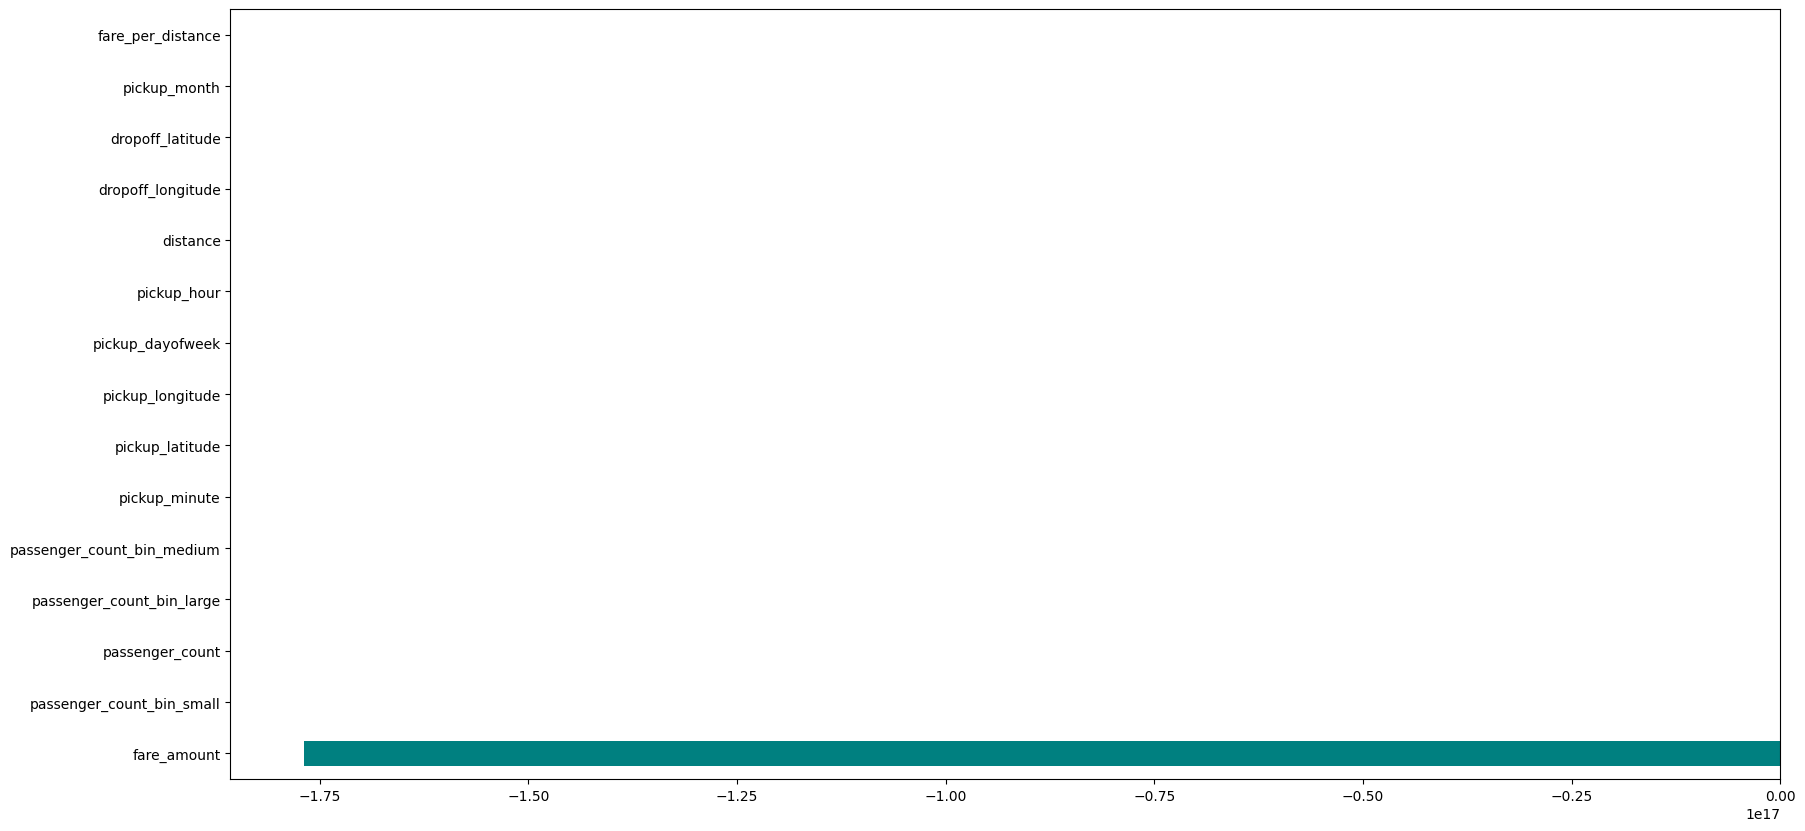

In [30]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

numericals = data
# numericals.replace([np.inf, -np.inf], np.nan, inplace=True)

# # Option 1: Fill NaN values with a specific value (e.g., the mean of the column)
# numericals.fillna(numericals.mean(), inplace=True)
y = data['fare_amount']

scores = f_classif(numericals,y)
plt.figure(figsize=(20,10))
feat_importance = pd.Series(scores[0], numericals.columns[:])
feat_importance = feat_importance.sort_values(ascending=True)
feat_importance.plot(kind='barh', color='teal')

### Outlier Detection

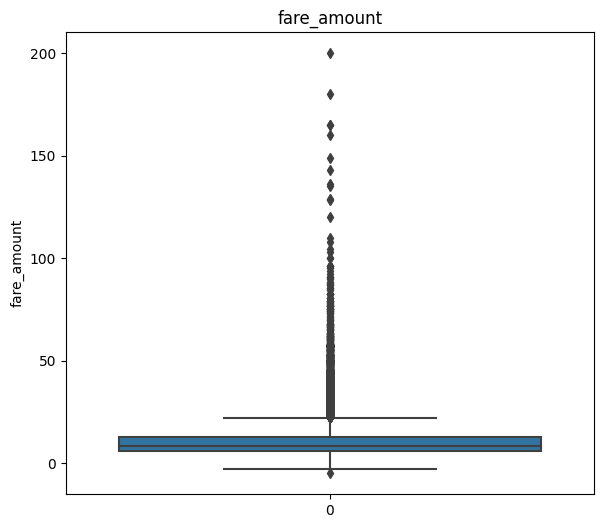

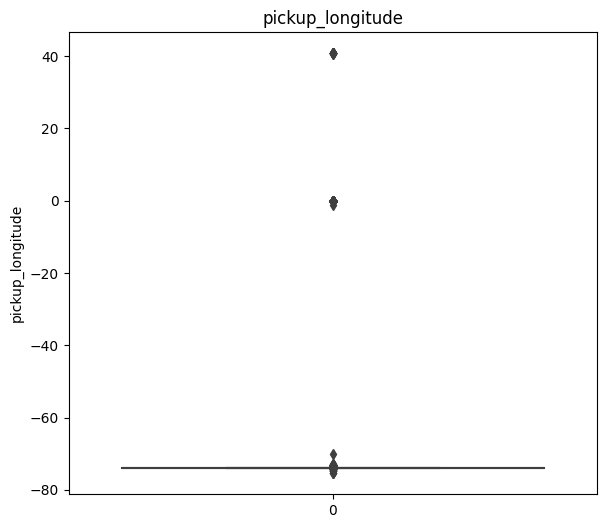

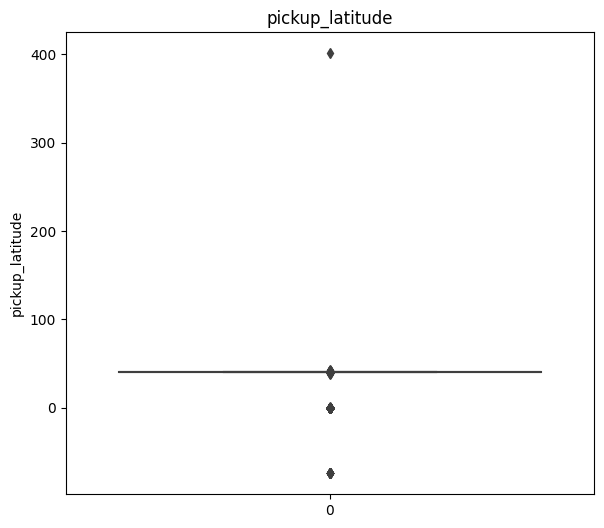

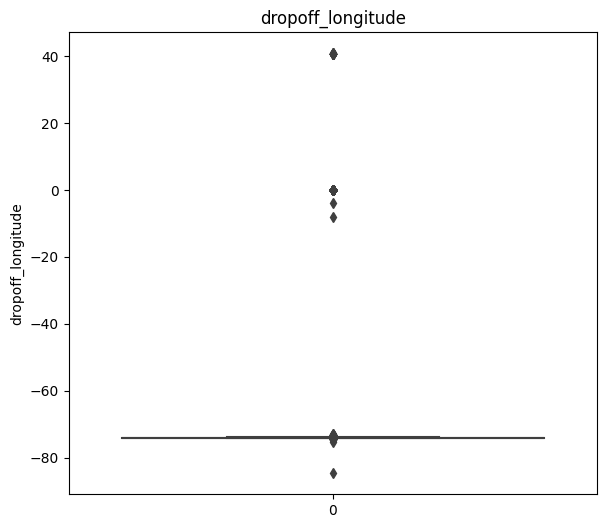

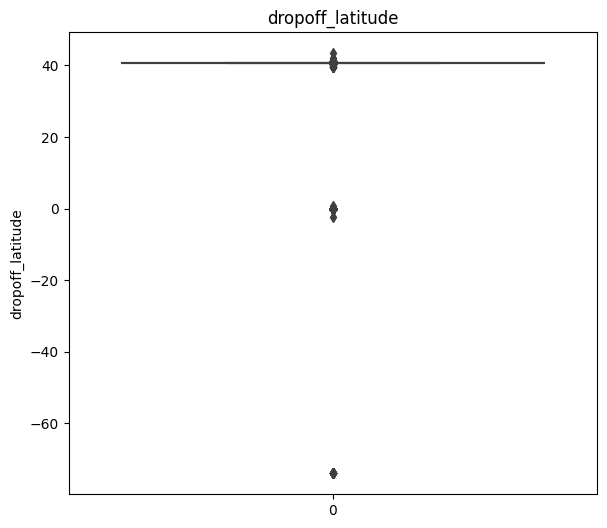

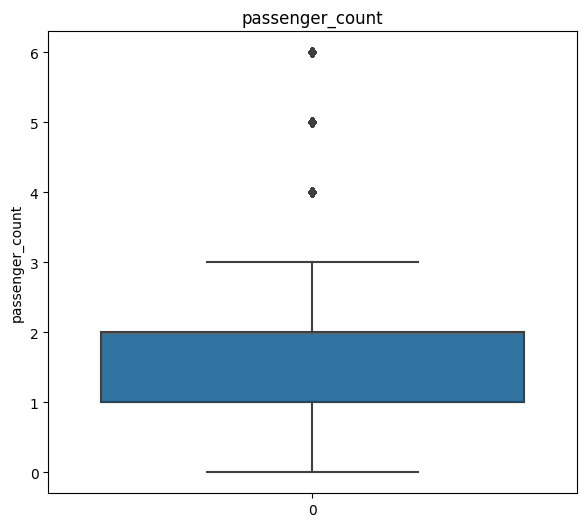

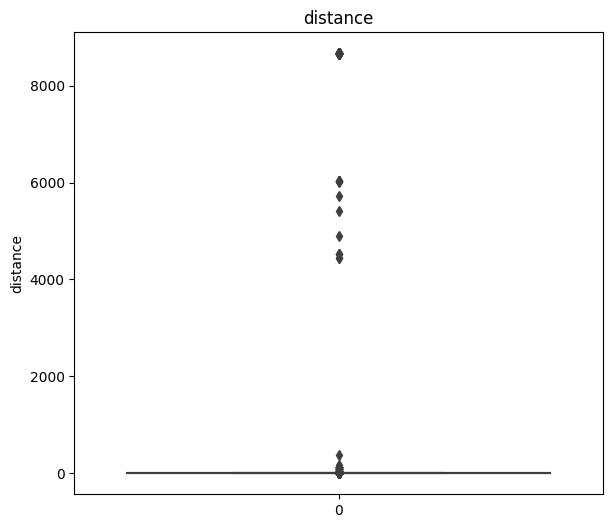

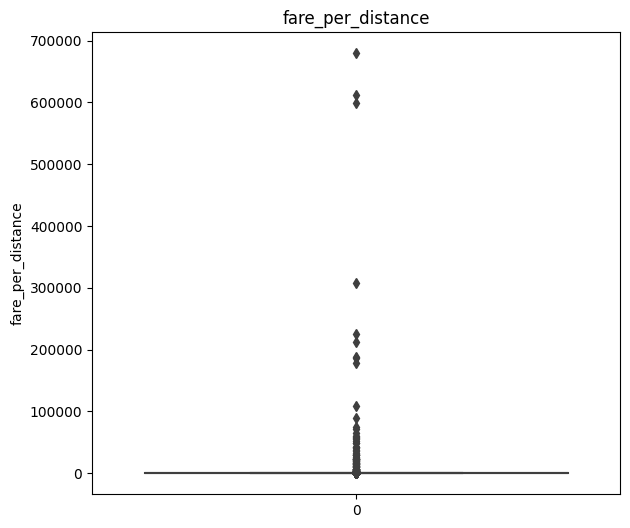

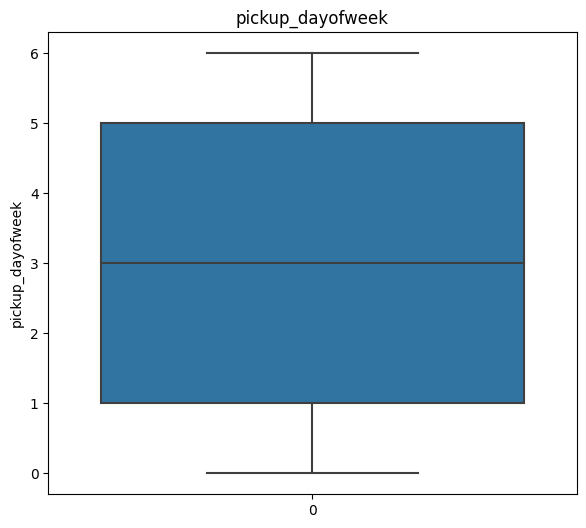

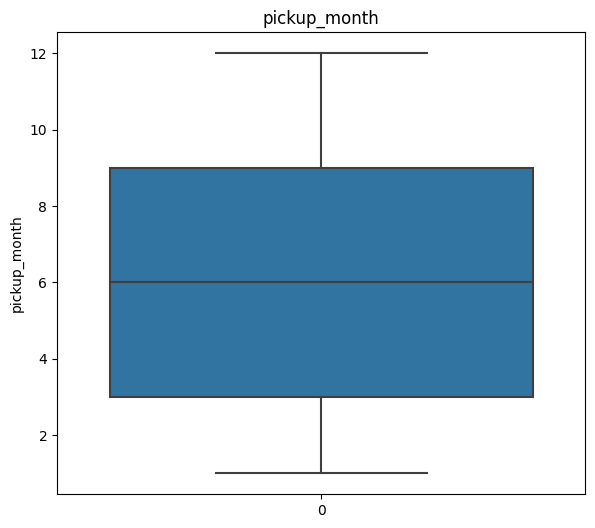

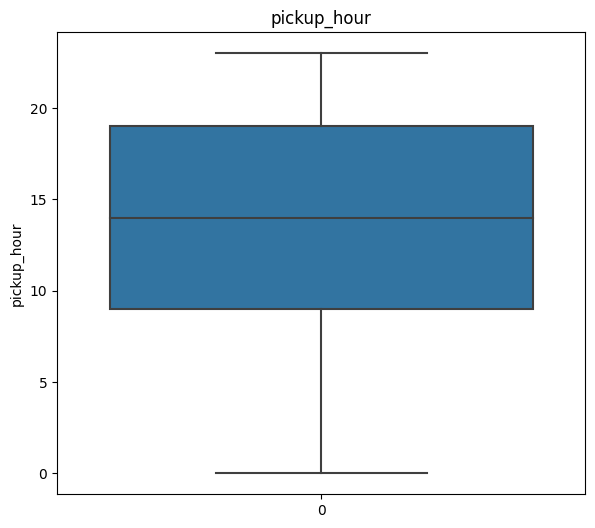

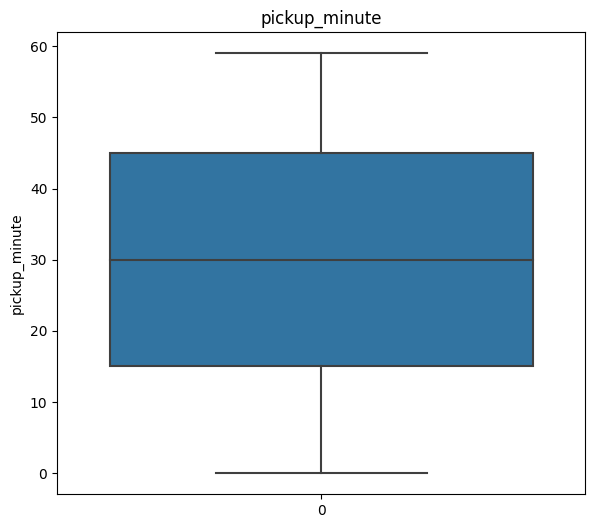

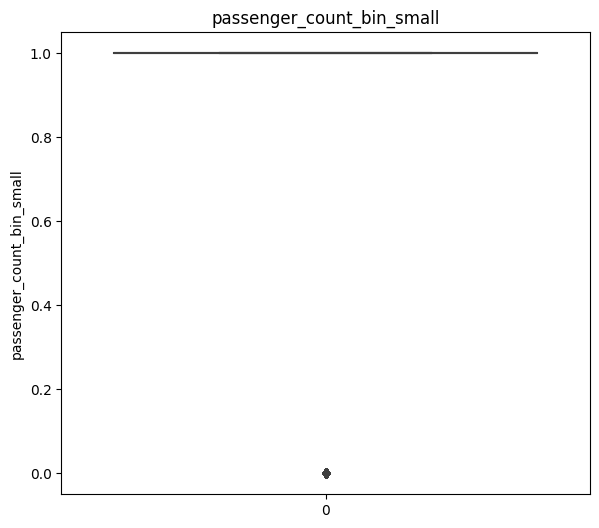

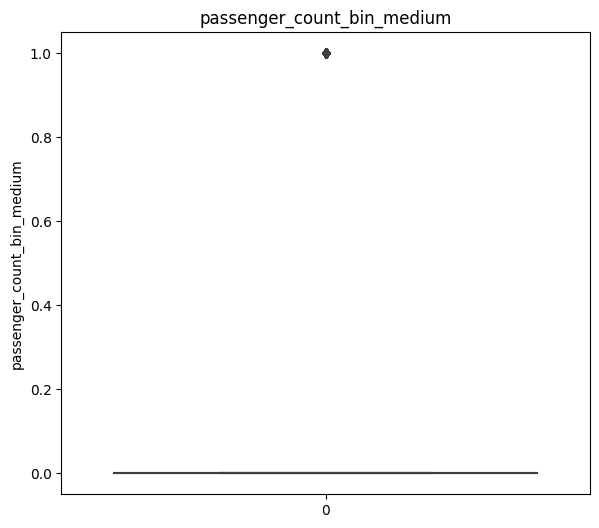

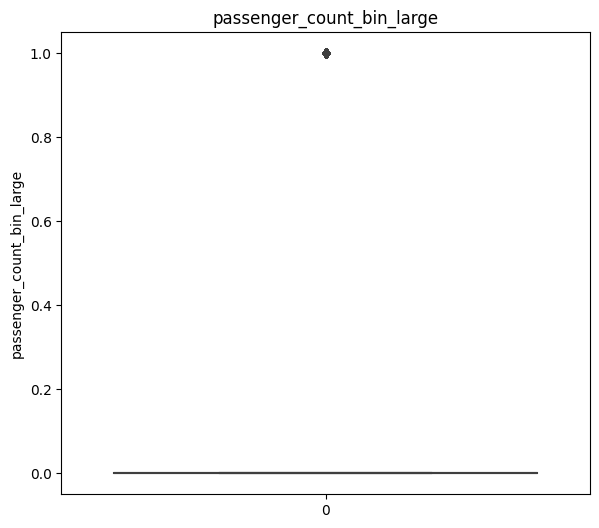

In [32]:
num_cols = data._get_numeric_data().columns
for var in num_cols:
    plt.figure(figsize=(15,6))
    plt.subplot(1,2,1)
    ax=sns.boxplot(data=data[var])
    ax.set_title(f'{var}')
    ax.set_ylabel(var)

fare_amount


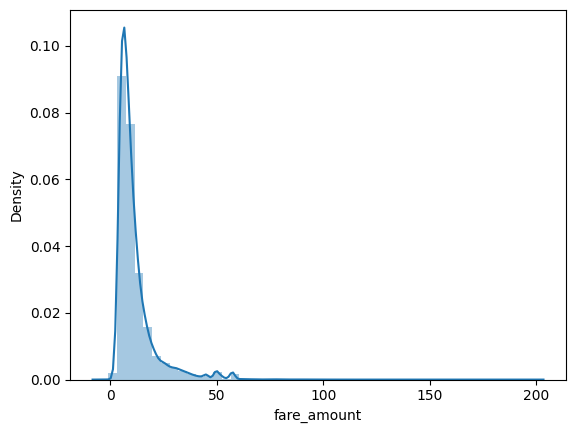

pickup_longitude


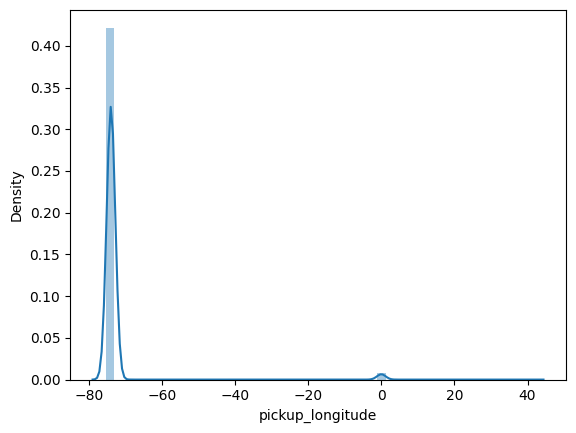

pickup_latitude


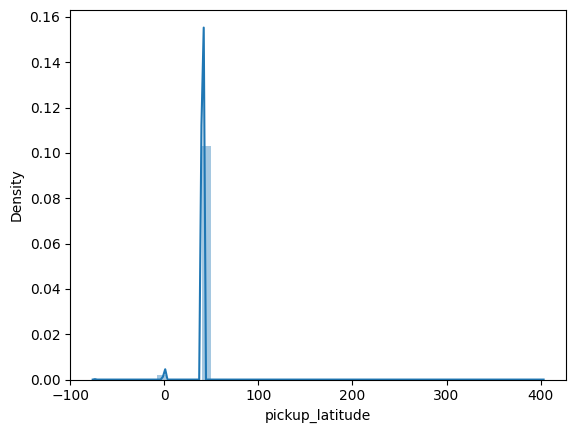

dropoff_longitude


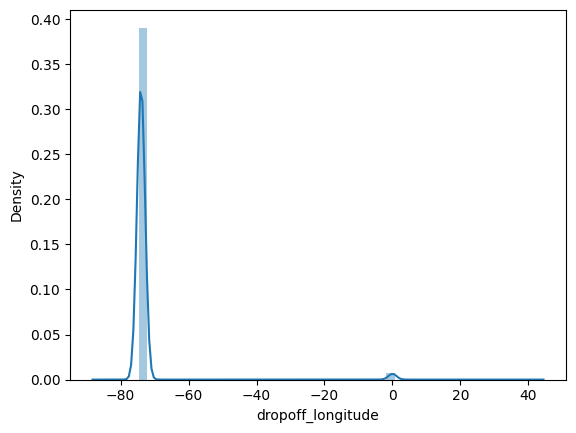

dropoff_latitude


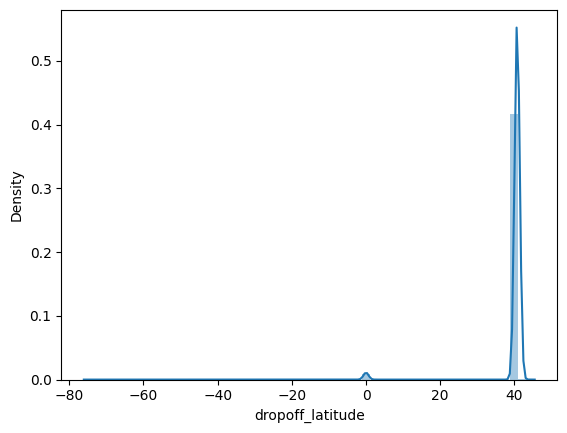

passenger_count


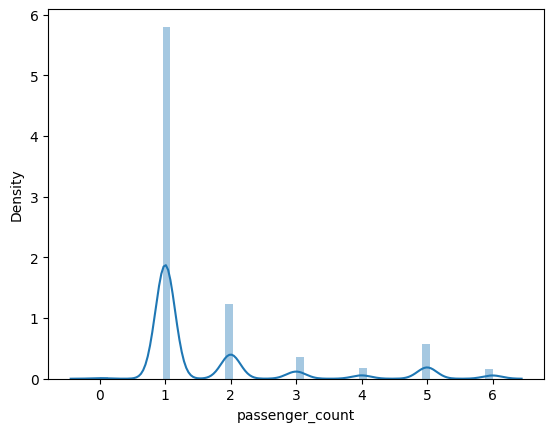

distance


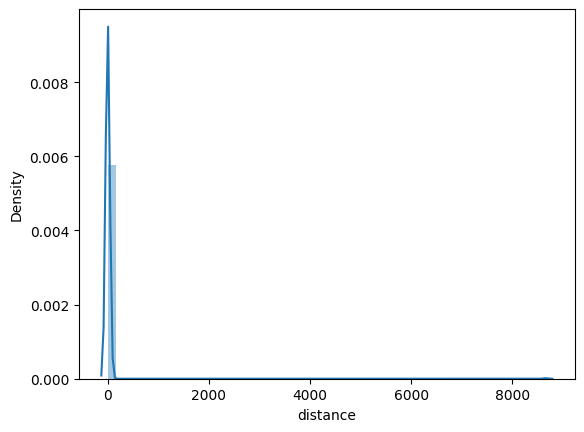

fare_per_distance


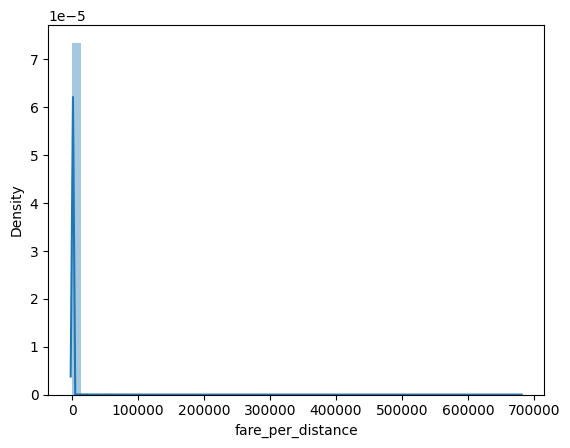

pickup_dayofweek


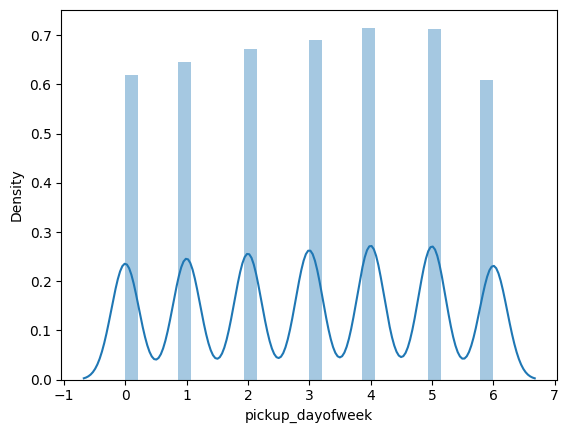

pickup_month


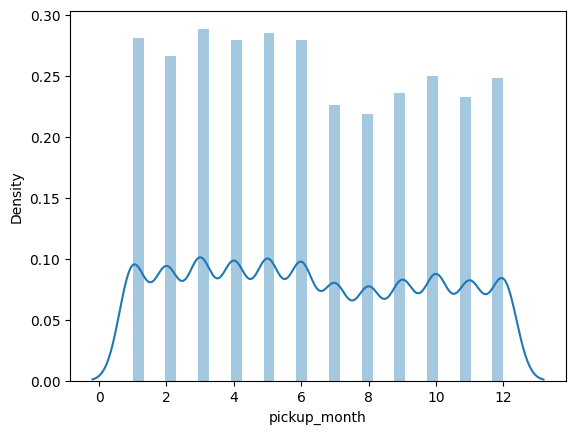

pickup_hour


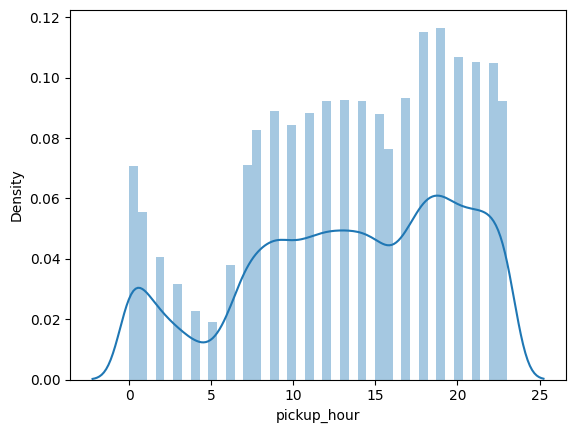

pickup_minute


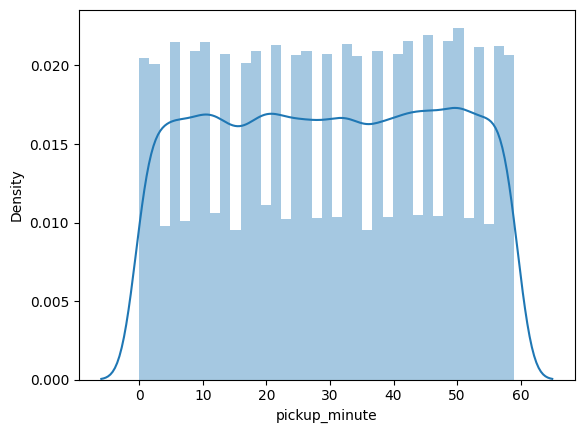

passenger_count_bin_small


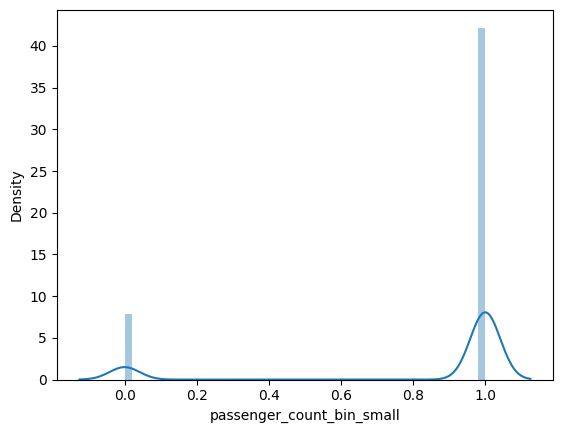

passenger_count_bin_medium


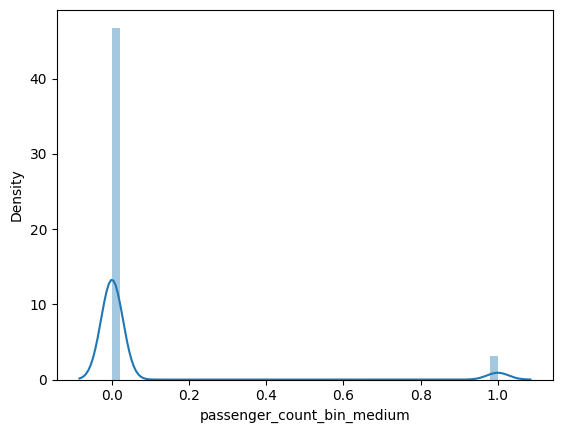

passenger_count_bin_large


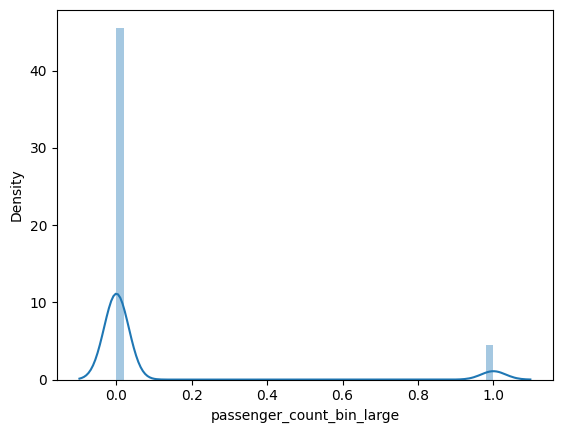

In [34]:
cols=data.columns
for col in cols:
  print(col)
  sns.distplot(data[col])
  plt.show()

### Removing Outlier

In [39]:
outlier_var=['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude',]

# Capping dataset
for i in outlier_var:
    # Findling IQR
    Q1=data[i].quantile(0.25)
    Q3=data[i].quantile(0.75)
    IQR=Q3-Q1

    # Defining upper and lower limit
    lower_limit =data[i].quantile(0.25)-1.5*IQR
    upper_limit =data[i].quantile(0.75)+1.5*IQR

    # Applying lower and upper limit to each variables
    data.loc[(data[i] > upper_limit),i] = np.nan
    data.loc[(data[i] < lower_limit),i] = np.nan


In [42]:

count_null_df=pd.DataFrame({'columns':data.columns,'number_of_nulls_values':data.isna().sum()})
count_null_df.set_index('columns').sort_values(by='number_of_nulls_values', ascending = False)

,number_of_nulls_values
columns,
dropoff_longitude,3589
pickup_longitude,3429
dropoff_latitude,3139
pickup_latitude,2363
fare_amount,0
passenger_count,0
distance,0
fare_per_distance,0
pickup_dayofweek,0


In [51]:
for col in data.columns:
    data = data[data[col].notna()]
     

In [53]:

count_null_df=pd.DataFrame({'columns':data.columns,'number_of_nulls_values':data.isna().sum()})
count_null_df.set_index('columns').sort_values(by='number_of_nulls_values', ascending = False)


,number_of_nulls_values
columns,
fare_amount,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,0
dropoff_latitude,0
passenger_count,0
distance,0
fare_per_distance,0
pickup_dayofweek,0


<Axes: xlabel='fare_amount', ylabel='Density'>

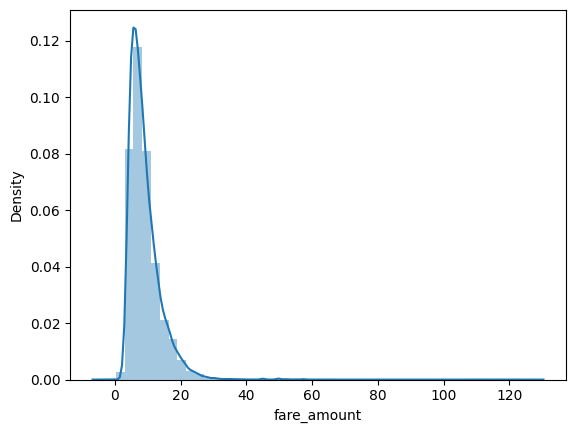

In [54]:

sns.distplot(data["fare_amount"])

# Modelling

In [55]:
y = data["fare_amount"].values
X = data.drop(["fare_amount"], axis=1).values

X

array([[-74.016048, 40.711303, -73.979268, ..., True, False, False],
       [-73.982738, 40.76127, -73.991242, ..., True, False, False],
       [-73.98713000000001, 40.733143, -73.991567, ..., True, False,
        False],
       ...,
       [-74.002698, 40.739428, -73.998108, ..., True, False, False],
       [-73.946062, 40.777567, -73.95345, ..., True, False, False],
       [-73.932603, 40.763805, -73.932603, ..., True, False, False]],
      dtype=object)

In [56]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
# define feature selection
fs = SelectKBest(score_func=f_regression, k=10)
# apply feature selection
X_selected = fs.fit_transform(X, y)
print(X_selected.shape)

(43170, 10)


### Data Split and Normalization

In [58]:
import sklearn
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(34536, 14) (8634, 14) (34536,) (8634,)


In [59]:

y_train = y_train/60
y_test = y_test/60

In [60]:

# Normalization
from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import StandardScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [62]:
from sklearn.metrics import mean_absolute_error
import numpy as np
# "Learn" the mean from the training data
mean_train = np.mean(y_train)
# Get predictions on the test set
baseline_predictions = np.ones(y_test.shape) * mean_train
# Compute MAE
mae_baseline = mean_absolute_error(y_test, baseline_predictions)
print("Baseline MAE is {:.2f}".format(mae_baseline))

Baseline MAE is 0.06


### Linear Regression Model

In [63]:
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, SGDRegressor, SGDRegressor
regressor = LinearRegression()
# regressor = Ridge(alpha=1.0)
regressor.fit(X_train, y_train)

LinearRegression()

In [64]:
y_pred = regressor.predict(X_test)

In [65]:

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
mae = mean_absolute_error(y_pred,y_test)

# R_square
r2 = r2_score(y_test, y_pred)

print('The MAE or J(theta) is: ',mae)
print('r2_score =',r2)

The MAE or J(theta) is:  0.030613490664719054
r2_score = 0.5987195911196757


### XG Boost

In [66]:

! pip install xgboost

In [67]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [68]:
params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:linear',
}

params['eval_metric'] = "mae"
num_boost_round = 999

model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Test-mae:0.04245
[1]	Test-mae:0.03112
[2]	Test-mae:0.02328
[3]	Test-mae:0.01760
[4]	Test-mae:0.01346
[5]	Test-mae:0.01070
[6]	Test-mae:0.00901
[7]	Test-mae:0.00769
[8]	Test-mae:0.00686
[9]	Test-mae:0.00637
[10]	Test-mae:0.00608
[11]	Test-mae:0.00588
[12]	Test-mae:0.00566
[13]	Test-mae:0.00548
[14]	Test-mae:0.00543
[15]	Test-mae:0.00537
[16]	Test-mae:0.00540
[17]	Test-mae:0.00541
[18]	Test-mae:0.00542
[19]	Test-mae:0.00541
[20]	Test-mae:0.00534
[21]	Test-mae:0.00534
[22]	Test-mae:0.00526
[23]	Test-mae:0.00523
[24]	Test-mae:0.00523
[25]	Test-mae:0.00518
[26]	Test-mae:0.00519
[27]	Test-mae:0.00516
[28]	Test-mae:0.00517
[29]	Test-mae:0.00517
[30]	Test-mae:0.00515
[31]	Test-mae:0.00518
[32]	Test-mae:0.00515
[33]	Test-mae:0.00512
[34]	Test-mae:0.00509
[35]	Test-mae:0.00512
[36]	Test-mae:0.00512
[37]	Test-mae:0.00512
[38]	Test-mae:0.00515
[39]	Test-mae:0.00515
[40]	Test-mae:0.00517
[41]	Test-mae:0.00516
[42]	Test-mae:0.00515
[43]	Test-mae:0.00515
[44]	Test-mae:0.00517


In [69]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'mae'},
    early_stopping_rounds=10
)
cv_results

,train-mae-mean,train-mae-std,test-mae-mean,test-mae-std
0,0.042702,0.000084,0.042807,0.000293
1,0.031452,0.000102,0.031671,0.000250
2,0.023510,0.000062,0.023802,0.000289
3,0.017821,0.000065,0.018212,0.000236
4,0.013802,0.000123,0.014237,0.000234
...,...,...,...,...
358,0.000938,0.000026,0.004606,0.000203
359,0.000938,0.000026,0.004606,0.000203
360,0.000938,0.000026,0.004606,0.000203
361,0.000938,0.000026,0.004606,0.000203


## Hyper-Parameter Tuning

In [70]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(9,12)
    for min_child_weight in range(5,8)
]

# Define initial best params and MAE
min_mae = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best MAE
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with max_depth=9, min_child_weight=5
	MAE 0.004668562807089222 for 17 rounds
CV with max_depth=9, min_child_weight=6
	MAE 0.004642313231343432 for 16 rounds
CV with max_depth=9, min_child_weight=7
	MAE 0.004775578292272356 for 14 rounds
CV with max_depth=10, min_child_weight=5
	MAE 0.004390192112925588 for 16 rounds
CV with max_depth=10, min_child_weight=6
	MAE 0.004462914375578484 for 15 rounds
CV with max_depth=10, min_child_weight=7
	MAE 0.004510182480496288 for 14 rounds
CV with max_depth=11, min_child_weight=5
	MAE 0.004283631865307872 for 15 rounds
CV with max_depth=11, min_child_weight=6
	MAE 0.00437756249091735 for 15 rounds
CV with max_depth=11, min_child_weight=7
	MAE 0.0044372655899535705 for 16 rounds
Best params: 11, 5, MAE: 0.004283631865307872


In [71]:

gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

min_mae = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (subsample,colsample)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with subsample=1.0, colsample=1.0
	MAE 0.0044372655899535705 for 16 rounds
CV with subsample=1.0, colsample=0.9
	MAE 0.00754715175083365 for 20 rounds
CV with subsample=1.0, colsample=0.8
	MAE 0.0074529477296541675 for 20 rounds
CV with subsample=1.0, colsample=0.7
	MAE 0.007882117498592972 for 38 rounds
CV with subsample=0.9, colsample=1.0
	MAE 0.004405123554406242 for 15 rounds
CV with subsample=0.9, colsample=0.9
	MAE 0.007675600820788714 for 19 rounds
CV with subsample=0.9, colsample=0.8
	MAE 0.007538669727996984 for 32 rounds
CV with subsample=0.9, colsample=0.7
	MAE 0.007960528578742071 for 26 rounds
CV with subsample=0.8, colsample=1.0
	MAE 0.004501344267333844 for 14 rounds
CV with subsample=0.8, colsample=0.9
	MAE 0.007684057641961313 for 18 rounds
CV with subsample=0.8, colsample=0.8
	MAE 0.0076426138730889175 for 20 rounds
CV with subsample=0.8, colsample=0.7
	MAE 0.008126972074893591 for 20 rounds
CV with subsample=0.7, colsample=1.0
	MAE 0.0047072269104020585 for 15 rou

In [72]:

min_mae = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    # Run and time CV
    cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=num_boost_round,
            seed=42,
            nfold=5,
            metrics=['mae'],
            early_stopping_rounds=10
          )
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds\n".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = eta
print("Best params: {}, MAE: {}".format(best_params, min_mae))

CV with eta=0.3
	MAE 0.008377962479227896 for 20 rounds

CV with eta=0.2
	MAE 0.00750904735182297 for 42 rounds

CV with eta=0.1
	MAE 0.006698477133753695 for 131 rounds

CV with eta=0.05
	MAE 0.006308096320502865 for 284 rounds

CV with eta=0.01
	MAE 0.00602955146117261 for 998 rounds

CV with eta=0.005
	MAE 0.00783410560849197 for 998 rounds

Best params: 0.01, MAE: 0.00602955146117261


In [73]:
params['max_depth'] = 11
params['min_child_weight'] = 5
params['eta'] = 0.001
params['subsample'] = 0.9
params['colsample_bytree'] = 1

model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Test-mae:0.05792
[1]	Test-mae:0.05786
[2]	Test-mae:0.05781
[3]	Test-mae:0.05775
[4]	Test-mae:0.05770
[5]	Test-mae:0.05764
[6]	Test-mae:0.05758
[7]	Test-mae:0.05753
[8]	Test-mae:0.05747
[9]	Test-mae:0.05742
[10]	Test-mae:0.05736
[11]	Test-mae:0.05731
[12]	Test-mae:0.05725
[13]	Test-mae:0.05720
[14]	Test-mae:0.05714
[15]	Test-mae:0.05709
[16]	Test-mae:0.05703
[17]	Test-mae:0.05698
[18]	Test-mae:0.05692
[19]	Test-mae:0.05687
[20]	Test-mae:0.05682
[21]	Test-mae:0.05676
[22]	Test-mae:0.05671
[23]	Test-mae:0.05665
[24]	Test-mae:0.05660
[25]	Test-mae:0.05654
[26]	Test-mae:0.05649
[27]	Test-mae:0.05643
[28]	Test-mae:0.05638
[29]	Test-mae:0.05633
[30]	Test-mae:0.05627
[31]	Test-mae:0.05622
[32]	Test-mae:0.05617
[33]	Test-mae:0.05611
[34]	Test-mae:0.05606
[35]	Test-mae:0.05600
[36]	Test-mae:0.05595
[37]	Test-mae:0.05590
[38]	Test-mae:0.05584
[39]	Test-mae:0.05579
[40]	Test-mae:0.05574
[41]	Test-mae:0.05568
[42]	Test-mae:0.05563
[43]	Test-mae:0.05558
[44]	Test-mae:0.05552
[45]	Test-mae:0.0554

In [74]:

import xgboost as xg
# xgb = xg.XGBRegressor(n_estimators=500, learning_rate=0.08, gamma=0, subsample=0.75,
#                            colsample_bytree=1, max_depth=3)
# xgb.fit(X_train,y_train)
pred = model.predict(dtest)
mae = mean_absolute_error(y_test, pred)
print(mae)

0.022762467740291004


In [75]:

r2 = r2_score(y_test, pred)
print(r2)

0.7849268972367018


## Trying Different Models

In [76]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
seed = 0

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

elnt = ElasticNet(random_state = seed)
rf =  RandomForestRegressor(n_jobs = -1, random_state = seed)
ab = AdaBoostRegressor(random_state = seed)
gb = GradientBoostingRegressor(random_state = seed)
#xgb = XGBRegressor(random_state = seed, n_jobs = -1)
lgb = LGBMRegressor(random_state = seed, n_jobs = -1)

def train_r2(model1):
    model1.fit(X_train, y_train)
    return mean_absolute_error(model1.predict(X_test), y_test)

'''Calculate and plot the training accuracy.'''
models = [elnt, rf, ab, gb, lgb]
training_score = []
for model in models:
    training_score.append(train_r2(model))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004269 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1646
[LightGBM] [Info] Number of data points in the train set: 34536, number of used features: 14
[LightGBM] [Info] Start training from score 0.151683


In [77]:

training_score

[0.057972654358339704,
 0.0018534134429773908,
 0.10877580126053198,
 0.020003622238125036,
 0.004461726590753278]

# Best Model

In [80]:
model= RandomForestRegressor(n_jobs = -1, random_state = seed)
train_r2(model)


0.0018534134429773908

In [82]:
pred = model.predict(X_test)
mae = mean_absolute_error(y_test, pred)
print(mae)


0.0018534134429773908
0.9591935546613125


In [83]:
r2 = r2_score(y_test, pred)
print(r2*100)

95.91935546613125
